# Proper Orthogonal Decomposition (POD) for Von Karman Vortex Street

This notebook is **standalone**, **text-rich**, and **source-driven**:

- all computational logic is implemented in `src/pod_analysis`,
- notebook cells only orchestrate API calls and present results,
- POD correctness is validated with strict numerical diagnostics.


## 0. Standalone run instructions

1. Open this notebook in the project root.
2. Make sure dependencies are installed.
3. Run cells top-to-bottom.

The notebook auto-adds `src/` to `sys.path`, so package install is not required for local execution.


In [1]:
import sys
from pathlib import Path
from pprint import pprint

from IPython.display import Image, Markdown, display

ROOT = Path.cwd()
SRC = ROOT / 'src'
if SRC.exists() and str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from pod_analysis import (
    AnalysisConfig,
    engineering_metrics,
    run_analysis,
    spectral_peak_lines,
    validate_pod_model,
)

print(f'Project root: {ROOT}')
print(f'Source package visible: {SRC.exists()}')


Project root: /Users/rezami/PycharmProjects/PythonProject5
Source package visible: True


## 1. What POD does and why it is useful

POD is the standard low-rank decomposition for high-dimensional snapshot data.

For fluid flows, POD provides:

- **coherent spatial structures** (modes),
- **temporal dynamics** (mode coefficients),
- **energy ranking** for principled model truncation,
- **optimal least-squares reconstruction** at fixed rank (Eckart-Young).

This makes POD central for reduced-order modeling, control-oriented state compression, denoising, and faster simulation surrogates.


## 2. Correct POD formulation

Given snapshot matrix $X \in \mathbb{R}^{n_t \times n_x}$ (`time x space`):

1. Mean-center snapshots: $\tilde{X} = X - \bar{X}$
2. Compact SVD: $\tilde{X} = U\Sigma V^T$
3. POD quantities:
- spatial modes $\Phi = V$
- temporal coefficients $A = U\Sigma = \tilde{X}\Phi$
- modal energy $E_i = \sigma_i^2 / \sum_j \sigma_j^2$

Rank-$r$ reconstruction:
$$X_r = A_r\Phi_r^T + \bar{X}$$

Error-optimality:
$$\|\tilde{X} - \tilde{X}_r\|_F^2 = \sum_{j=r+1}^{k} \sigma_j^2$$


## 3. POD method variants (when each is appropriate)

- **Direct compact SVD POD**: robust default; used by this project.
- **Method of snapshots POD**: efficient when spatial dimension is huge ($n_x \gg n_t$).
- **Weighted POD**: required when physical norm differs from Euclidean norm.
- **SPOD**: preferred for frequency-resolved turbulent coherence analysis.


## 4. Run full workflow (all logic lives in source package)

In [2]:
config = AnalysisConfig(
    data_path=Path('vortex_data.mat'),
    output_dir=Path('outputs/notebook'),
    modes=None,
    energy_target=0.95,
    grid_shape=None,
    snapshot_index=None,
    dt=1.0,
    generate_plots=True,
    auto_download=False,
)

result = run_analysis(config)

display(Markdown(
    f"### Run Summary\n"
    f"- Snapshots: **{result.dataset.n_snapshots}**\n"
    f"- Spatial points: **{result.dataset.n_spatial_points:,}**\n"
    f"- Selected modes: **{result.selected_modes}**\n"
    f"- Captured energy: **{result.summary['pod']['selected_energy_percent']:.2f}%**"
))


### Run Summary
- Snapshots: **151**
- Spatial points: **89,351**
- Selected modes: **5**
- Captured energy: **95.42%**

## 5. Strict correctness checks (source API)

`validate_pod_model(...)` runs the complete diagnostic bundle:

- core POD identity checks (orthogonality, projection, Parseval),
- theoretical vs empirical truncated-SVD RMSE agreement,
- direct POD vs method-of-snapshots singular-value consistency.


In [3]:
validation = validate_pod_model(
    pod=result.pod,
    X=result.dataset.snapshots,
    selected_modes=result.selected_modes,
    max_modes=30,
    atol=1e-8,
    snapshot_rtol=1e-8,
)

pprint(validation.to_dict())
assert validation.passed, 'POD validation failed.'


{'consistency': {'cumulative_energy_is_monotonic': True,
                 'energy_sum_error': 1.1102230246251565e-16,
                 'energy_vector_relative_error': 0.0,
                 'max_modes_checked': 30,
                 'orthonormality_fro_error': 8.079356959644657e-14,
                 'parseval_relative_error': 8.990498109611151e-14,
                 'passed': True,
                 'projection_relative_error': 4.330497999716011e-15,
                 'rmse_curve_is_monotonic': True},
 'empirical_rmse': 0.11760323414283849,
 'passed': True,
 'rmse_abs_difference': 2.7755575615628914e-17,
 'snapshot_modes_compared': 12,
 'snapshot_singular_value_relative_error': 2.102916791265567e-15,
 'theoretical_rmse': 0.11760323414283852}


## 6. Engineering metrics and interpretation

In [4]:
metrics = engineering_metrics(result.summary, top_modes=6)
pprint(metrics)

print('Dominant temporal frequencies (first 4 modes):')
for line in spectral_peak_lines(result.summary['spectral_peaks']):
    print('  ' + line)


{'compression_ratio_selected': 25.131,
 'mode_counts_for_energy': {'90_percent': 4, '95_percent': 5, '99_percent': 7},
 'reconstruction_relative_l2': 0.105195,
 'reconstruction_rmse': 0.117603,
 'selected_energy_percent': 95.422,
 'selected_modes': 5,
 'top_energies_percent': [41.343, 40.172, 5.345, 5.28, 3.282, 3.145]}
Dominant temporal frequencies (first 4 modes):
  Mode 1: f=0.033113, amp=11276.74
  Mode 2: f=0.033113, amp=11117.97
  Mode 3: f=0.066225, amp=4055.05
  Mode 4: f=0.066225, amp=4029.98


## 7. Generated figures

#### Energy Spectrum

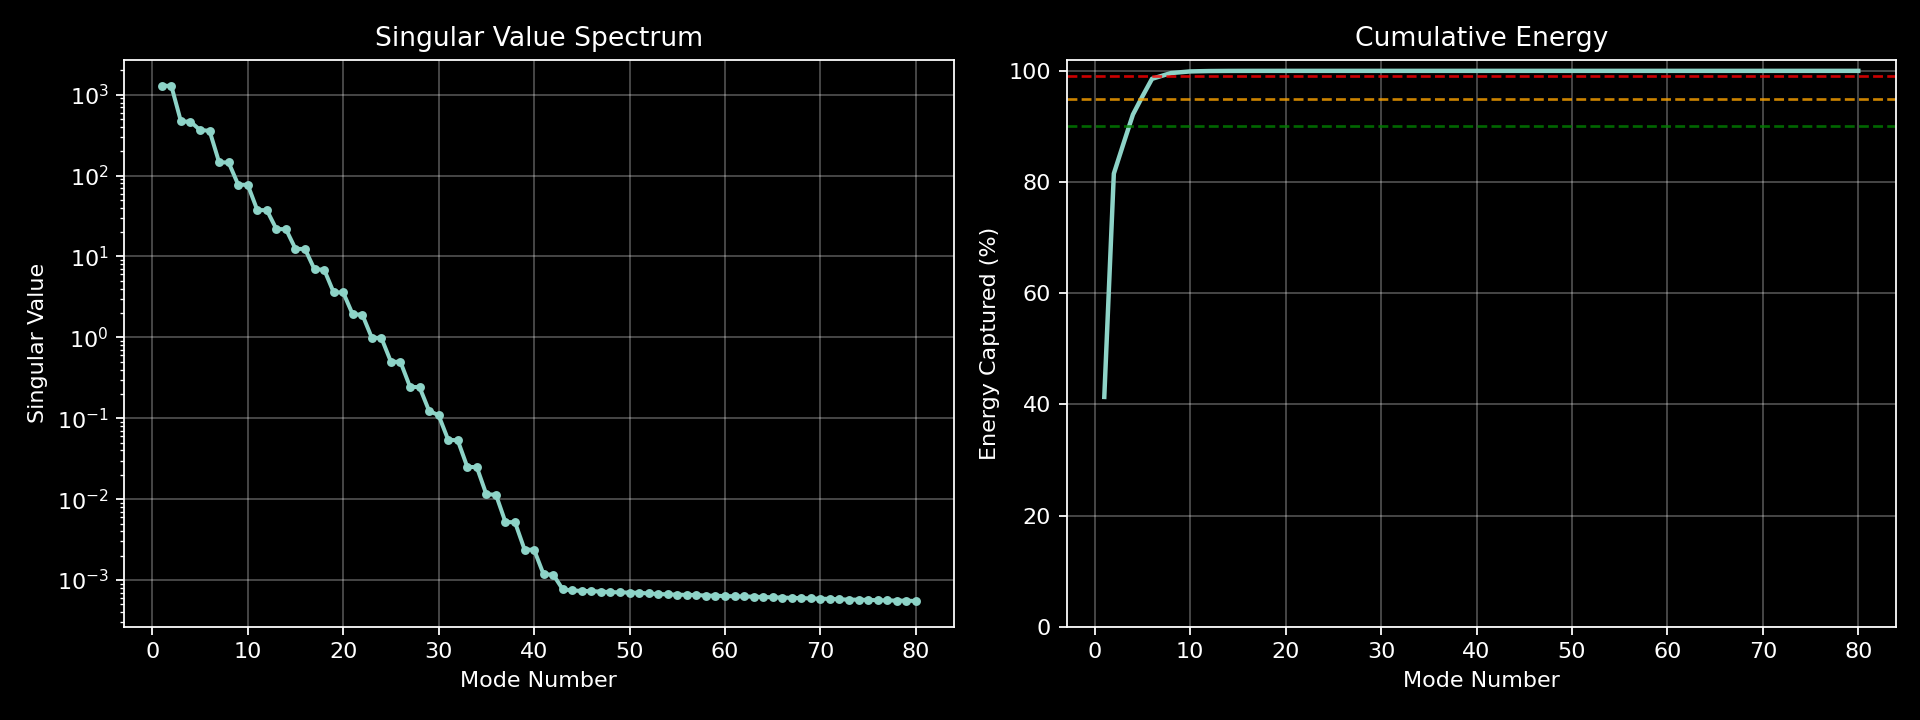

#### Spatial Modes

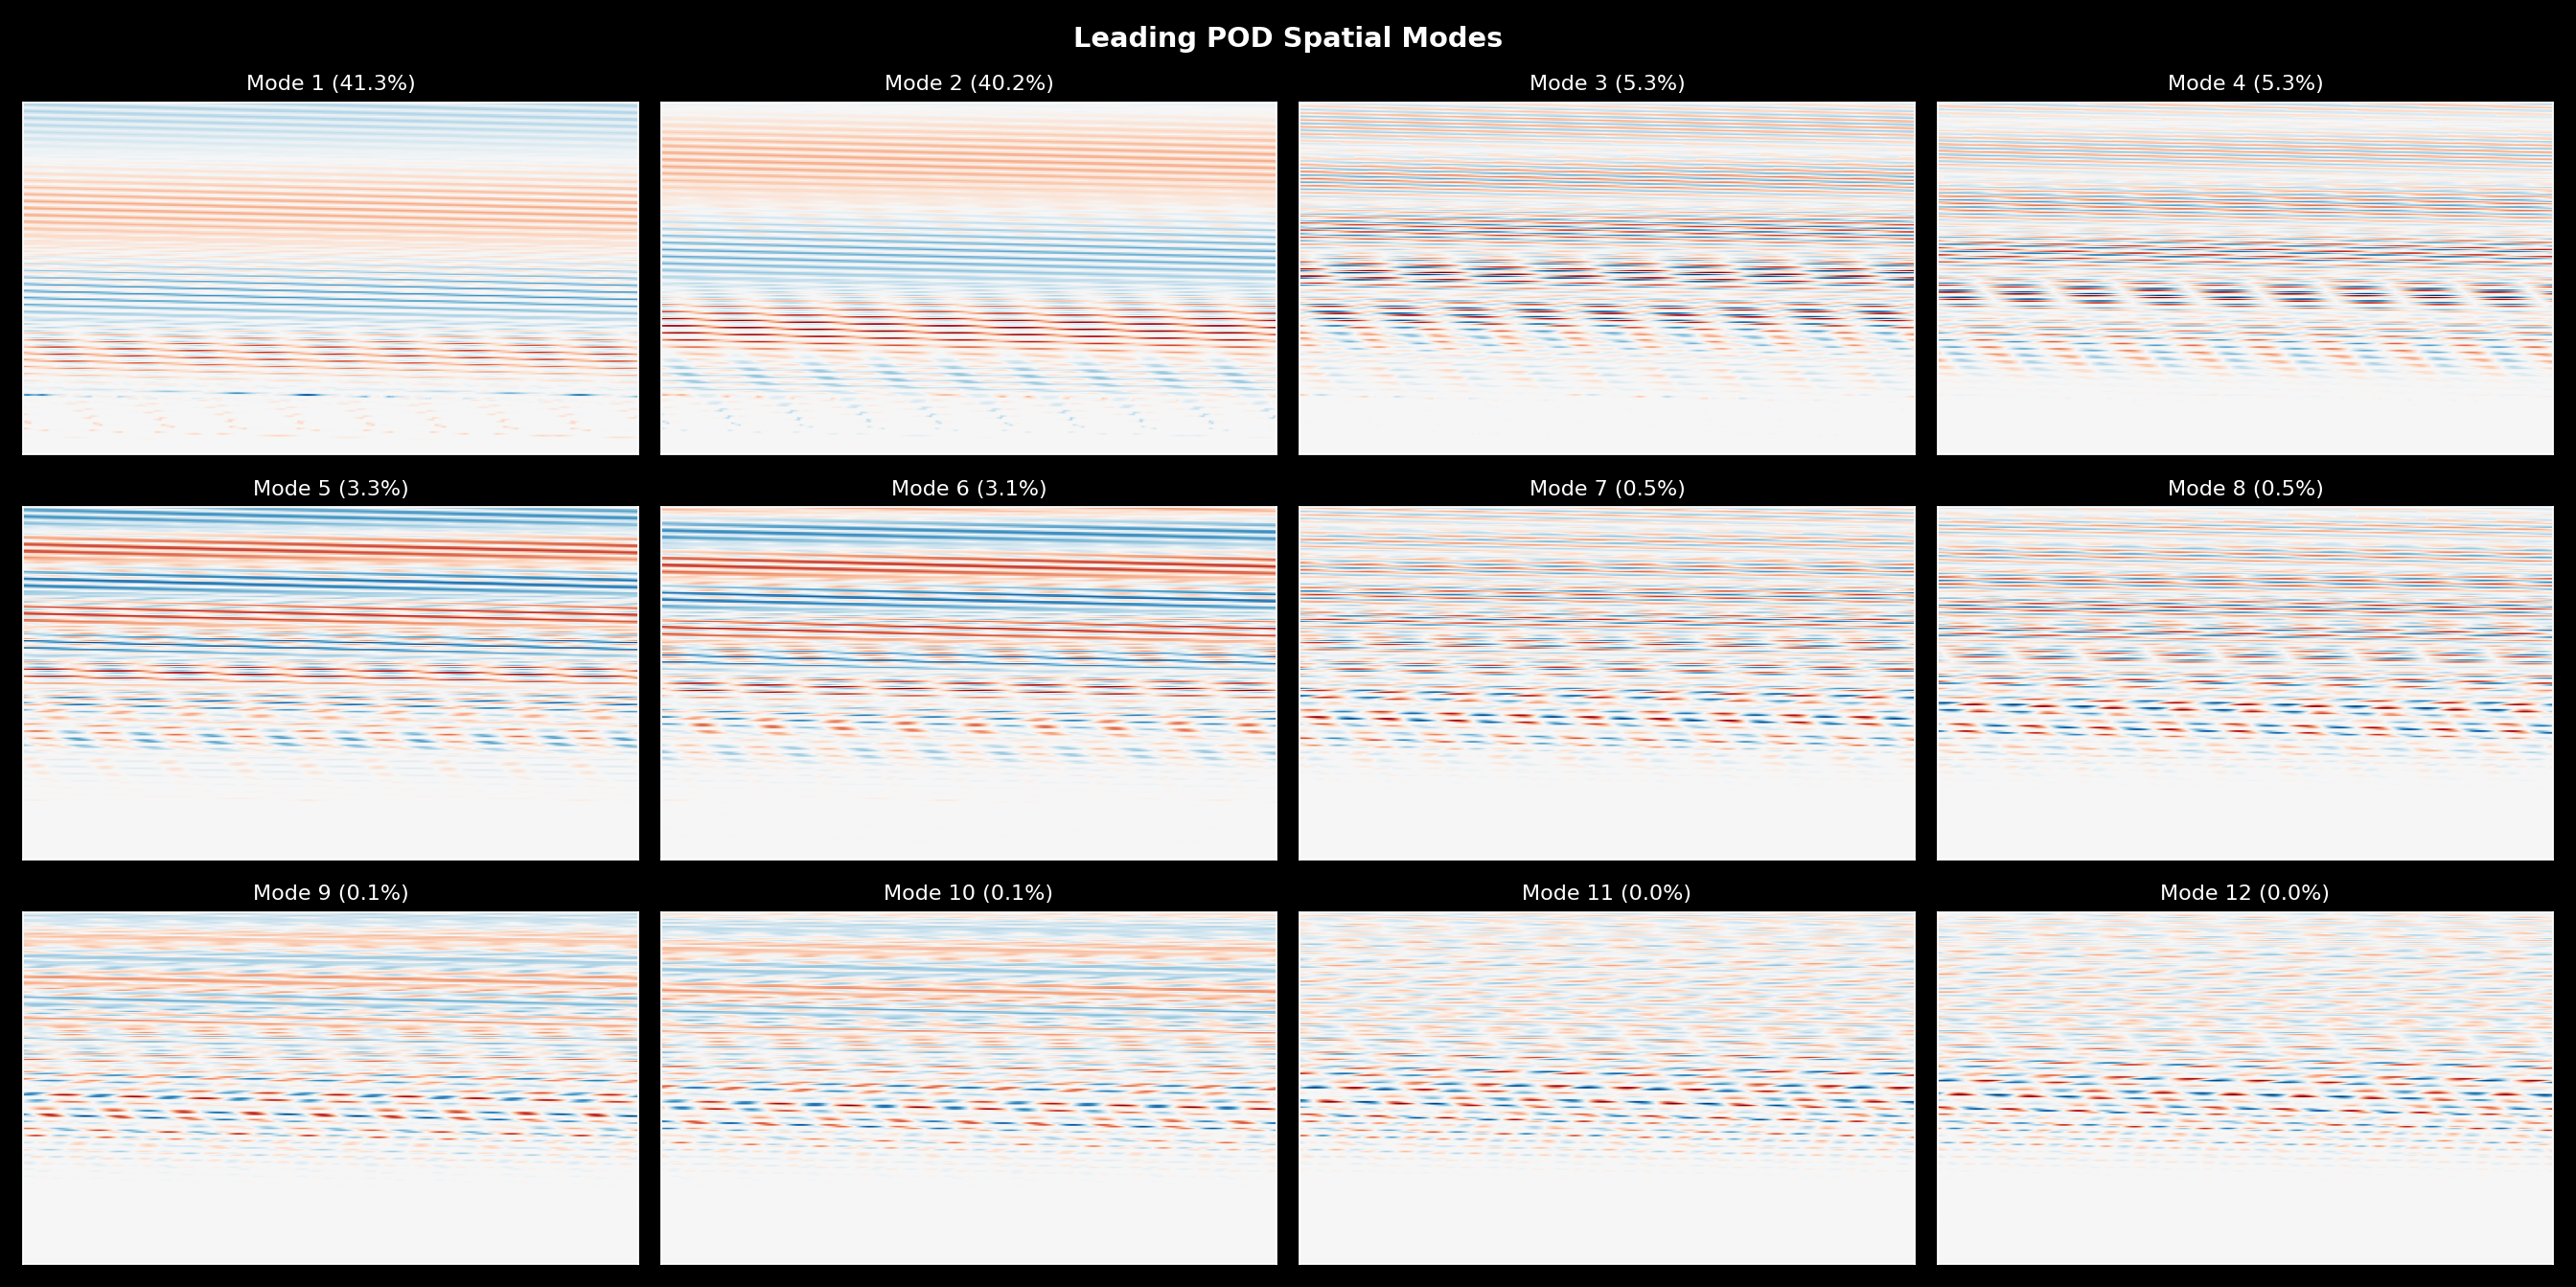

#### Reconstructions

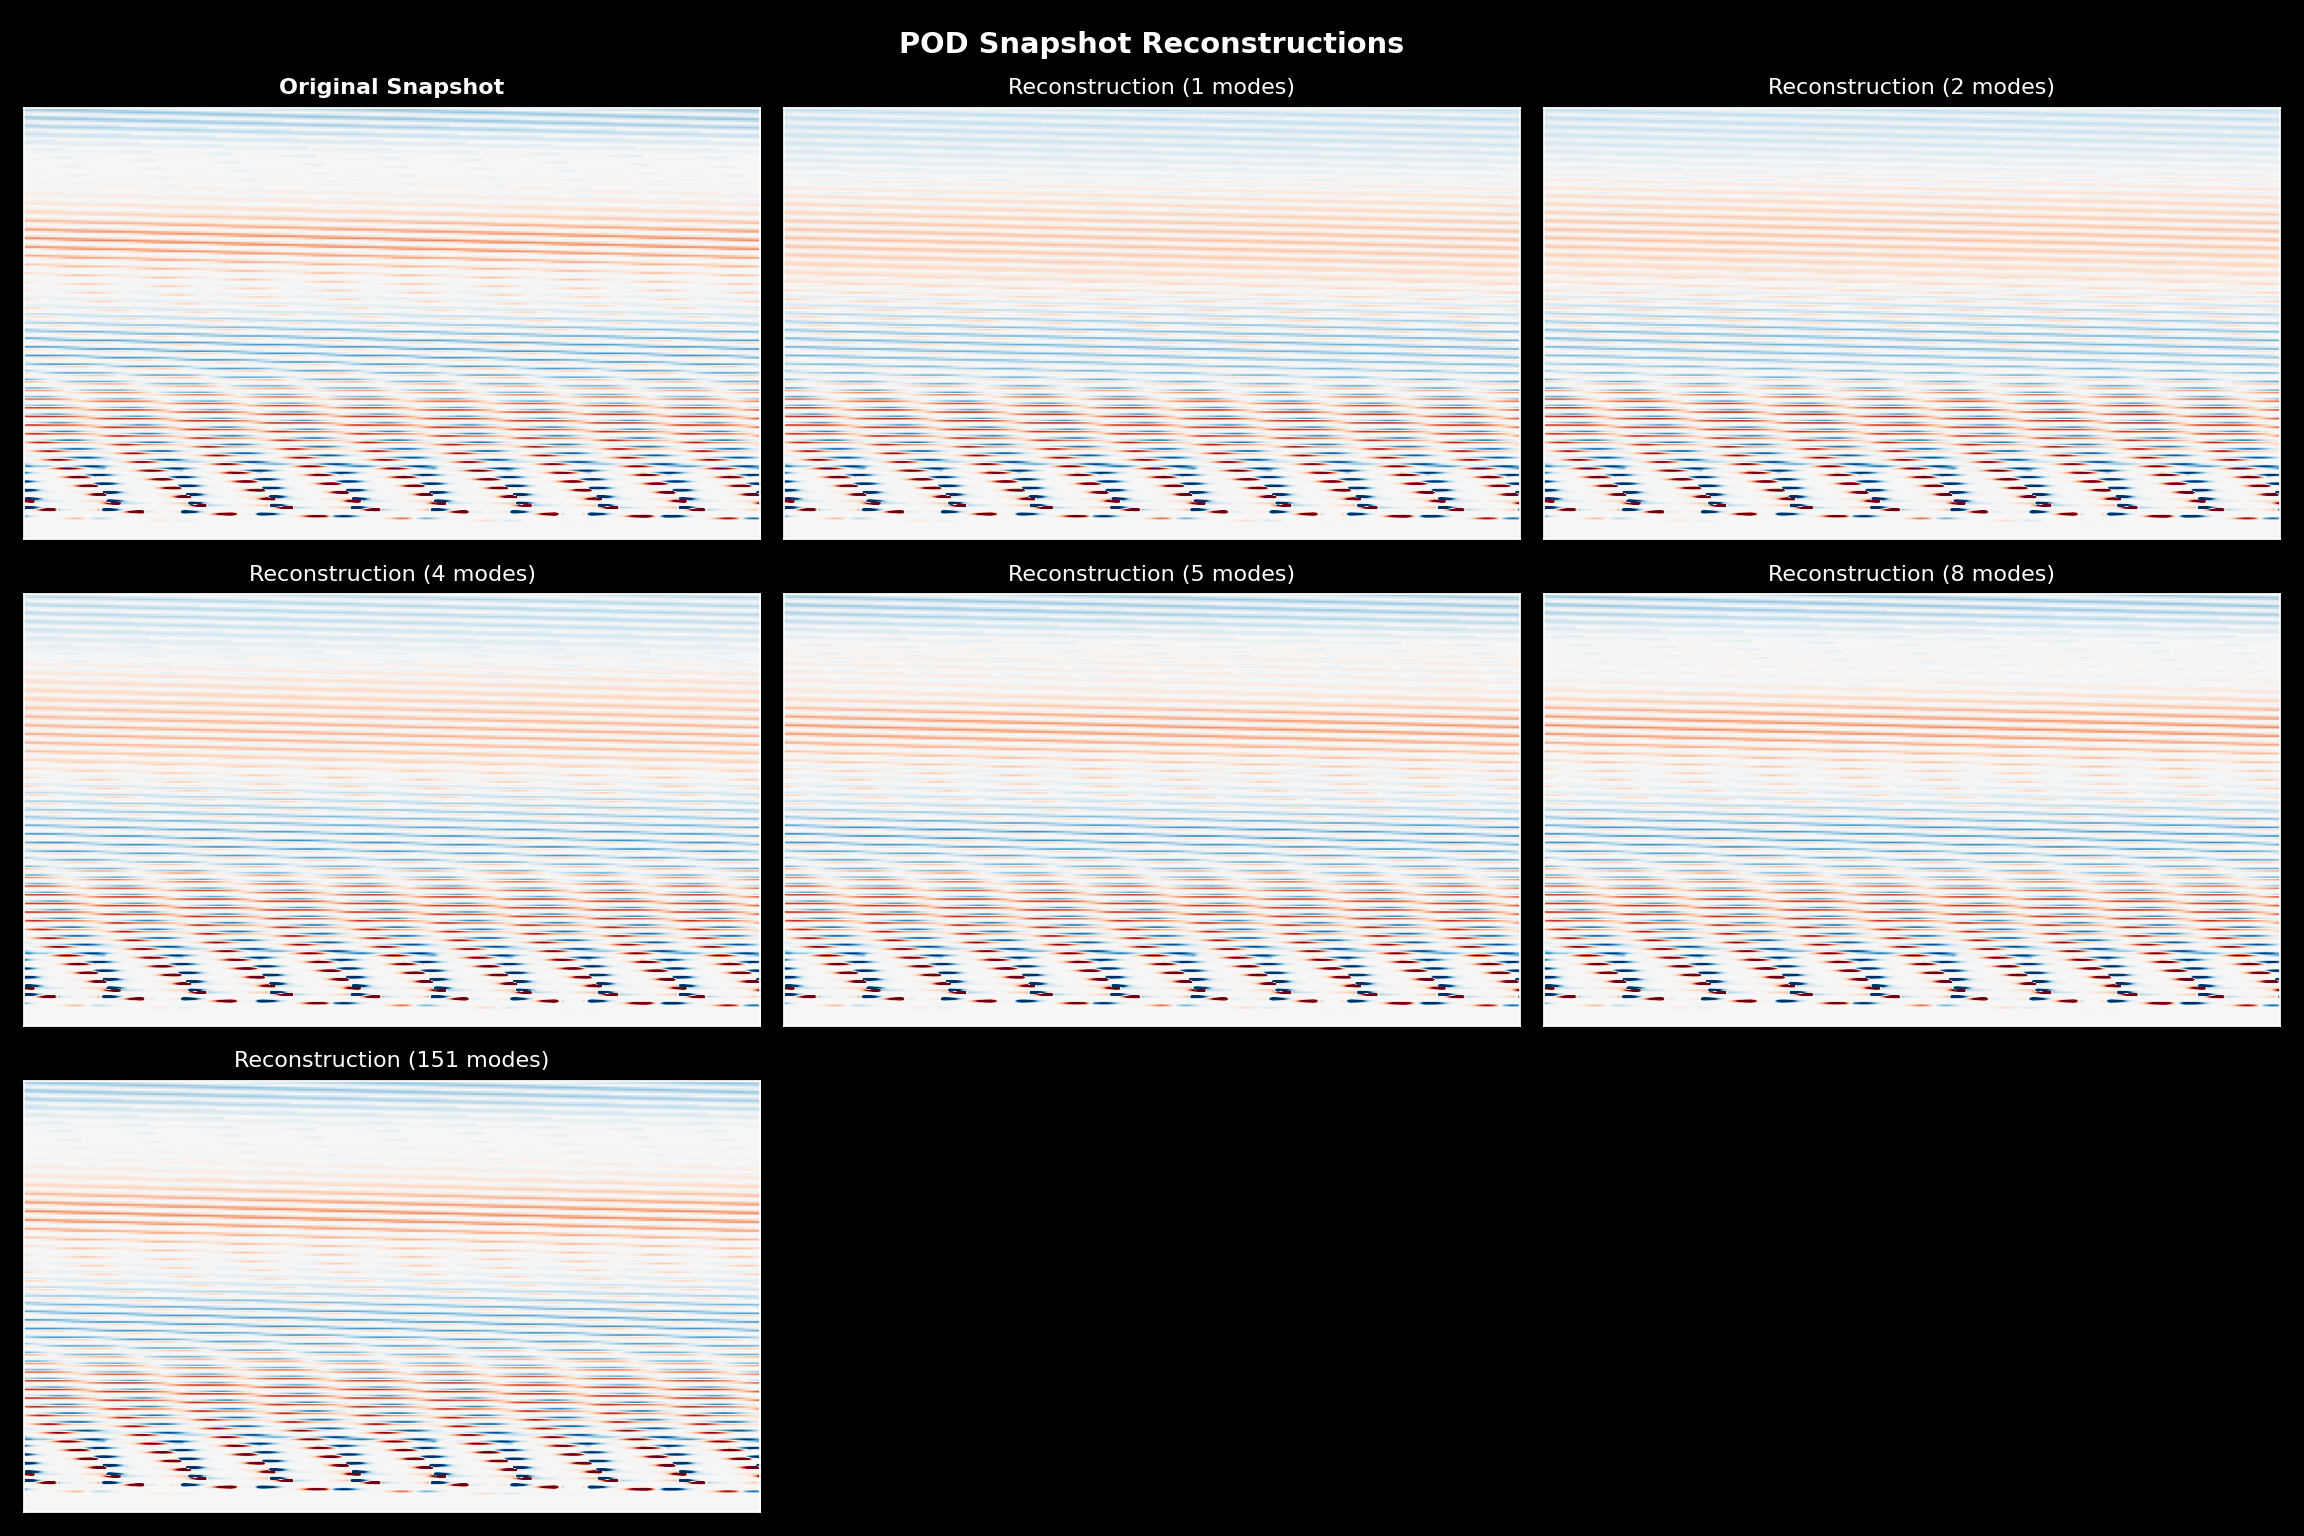

#### Temporal Coefficients

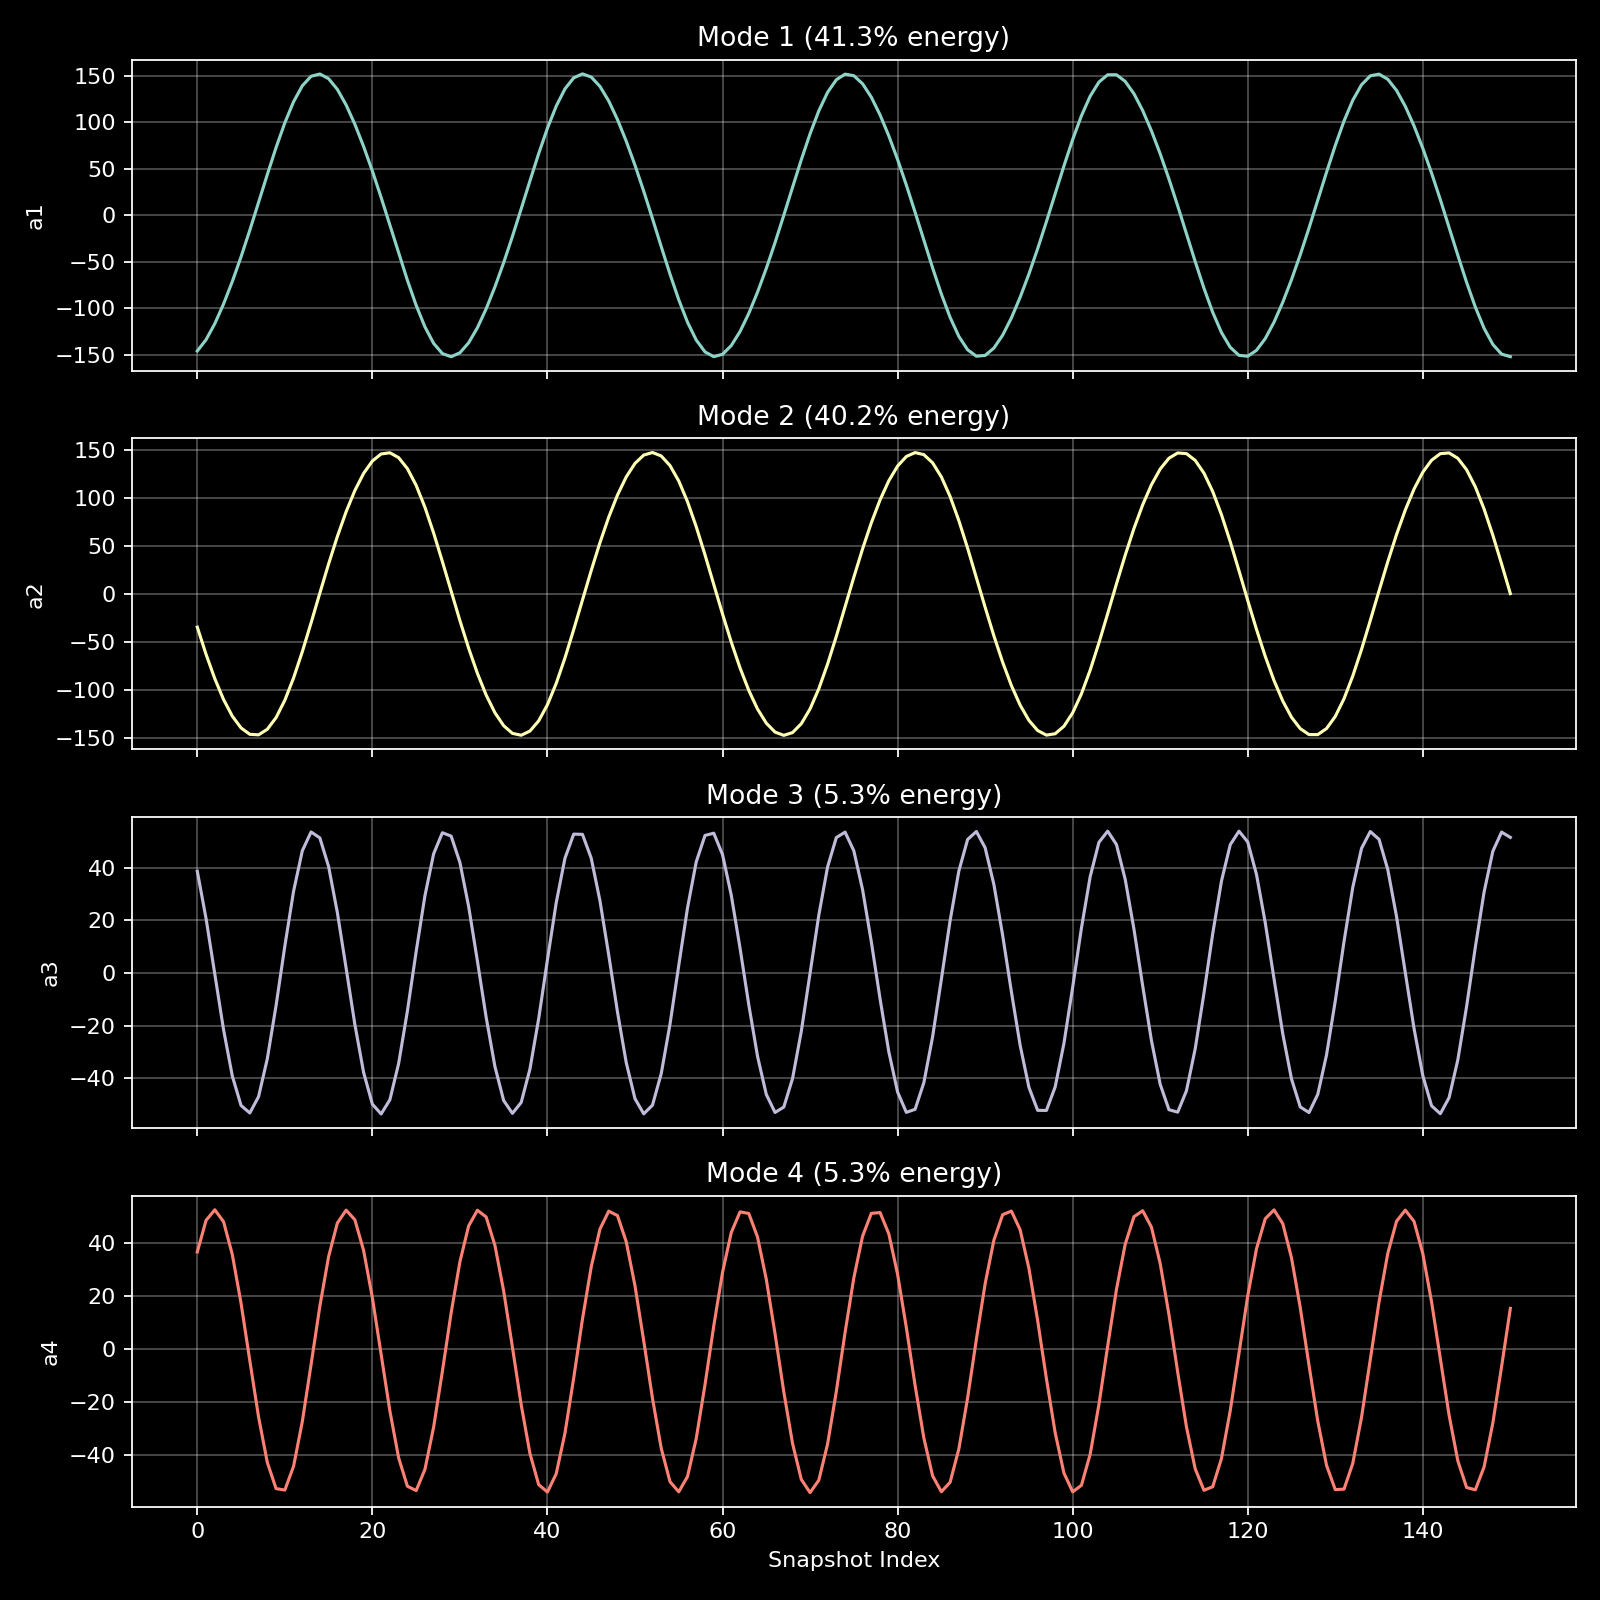

In [5]:
for label, path in result.generated_files.items():
    if path.suffix.lower() == '.png':
        display(Markdown(f"#### {label.replace('_', ' ').title()}"))
        display(Image(filename=str(path)))


## 8. Practical value, limits, and good-practice checklist

### Practical value
- compact reduced-order states for control/estimation
- interpretable coherent structures
- denoising by removing low-energy modes
- storage and transmission compression

### Limits
- linear subspace assumption may miss strongly nonlinear manifolds
- energy optimality is not always dynamics optimality
- near-degenerate modes may swap order/sign without physical change

### Checklist
- center data before POD
- select rank via both energy and task-level error
- validate POD identities numerically
- interpret mode pairs jointly (frequency + phase)

## References
- Brunton & Kutz, *Data-Driven Science and Engineering*
- Holmes et al., *Turbulence, Coherent Structures, Dynamical Systems and Symmetry*
- Eckart & Young (1936), optimal low-rank approximation
